In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import TimeDistributed, LSTM
from keras.src.legacy.preprocessing.image import ImageDataGenerator

In [2]:
from tensorflow.keras import models,layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [3]:
IMG_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS=50
LATENT_DIM = 100  # Dimension of the random noise
NUM_CLASSES = 7  # Number of classes

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("../Trash_Dataset/",
                                                            shuffle=True,
                                                            image_size=(IMG_SIZE, IMG_SIZE),
                                                            batch_size=BATCH_SIZE)

'''
# Function to resize and preprocess images
def preprocess_images(image):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

# Example: Load and preprocess your dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'path_to_train_data',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    label_mode=None
).map(preprocess_images)'''


Found 2527 files belonging to 6 classes.


"\n# Function to resize and preprocess images\ndef preprocess_images(image):\n    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))\n    image = (image - 127.5) / 127.5  # Normalize to [-1, 1]\n    return image\n\n# Example: Load and preprocess your dataset\ntrain_ds = tf.keras.preprocessing.image_dataset_from_directory(\n    'path_to_train_data',\n    batch_size=BATCH_SIZE,\n    image_size=(IMG_SIZE, IMG_SIZE),\n    label_mode=None\n).map(preprocess_images)"

In [6]:
class_names=dataset.class_names
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [7]:
len(dataset)

79

2024-08-04 20:58:00.567820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


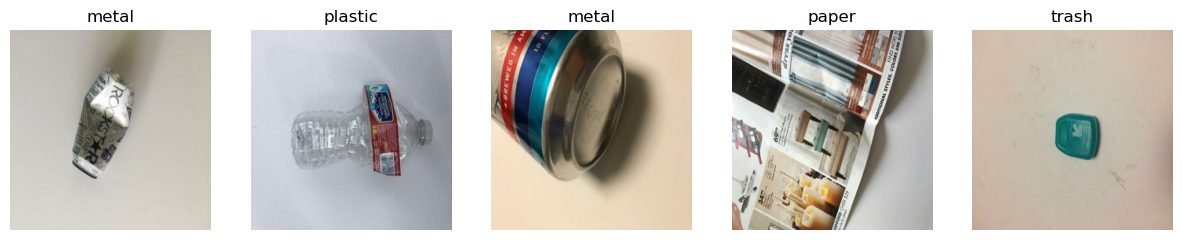

In [8]:
plt.figure(figsize=(15,15))
for image_batch,labels_batch in dataset.take(1):
    for i in range(5):
        ax=plt.subplot(4,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')
        #print(image_batch[i].shape)
        #print(labels_batch.numpy())

In [9]:
train_size=0.8
(len(dataset)*(train_size))

63.2

In [10]:
train_ds=dataset.take(14)
len(train_ds)

14

In [11]:
test_ds=dataset.skip(14)
len(test_ds)

65

In [12]:
val_size=0.1
(len(dataset)*val_size)

7.9

In [13]:
val_ds=test_ds.take(1)
len(val_ds)

1

In [14]:
test_ds=test_ds.skip(1)
len(test_ds)

64

In [16]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    
    ds_size = len(ds)
    if shuffle:  
        ds=ds.shuffle(shuffle_size,seed=12)
    
     
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds=ds.take(train_size)
  
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [17]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

63

In [19]:
len(val_ds)

7

In [20]:
len(test_ds)

9

### Cache, Shuffle, and Prefetch the Dataset

In [21]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
## Building the Model

In [22]:
resize_and_rescale=tf.keras.Sequential([
     tf.keras.layers.Resizing(IMG_SIZE,IMG_SIZE),
     tf.keras.layers.Rescaling(1./255)
])

In [ ]:
##Data Augmentation

# Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [23]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
## CNN Model

In [ ]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)  # Ensure CHANNELS is 3 for RGB images
n_classes = 7

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# Building the model 
model.build(input_shape=input_shape)

model.summary()


In [ ]:
## Compiling the CNN Model

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 660ms/step - accuracy: 0.2349 - loss: 1.7811 - val_accuracy: 0.4420 - val_loss: 1.5128
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 597ms/step - accuracy: 0.3660 - loss: 1.5428 - val_accuracy: 0.4509 - val_loss: 1.3651
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 620ms/step - accuracy: 0.4217 - loss: 1.4121 - val_accuracy: 0.3661 - val_loss: 1.4491
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 643ms/step - accuracy: 0.4147 - loss: 1.4165 - val_accuracy: 0.4554 - val_loss: 1.2635
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 690ms/step - accuracy: 0.4673 - loss: 1.3294 - val_accuracy: 0.4420 - val_loss: 1.2557
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 621ms/step - accuracy: 0.4949 - loss: 1.2705 - val_accuracy: 0.5312 - val_loss: 1.1489
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 635ms/step - accuracy: 0.5498 - loss: 1.1376 - val_accuracy: 0.5223 - val_loss: 1.1940
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 687ms/step - accuracy: 0.5459 - loss: 1.1569 - val_accu

In [28]:
scores = model.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.8305 - loss: 0.4249


In [35]:
scores

[0.422001451253891, 0.8263888955116272]

In [ ]:
## Plotting the Accuracy and Loss Curves CNN Model

In [36]:
history

In [37]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 63}

In [38]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [39]:
type(history.history['loss'])

list

In [40]:
len(history.history['loss'])

50

In [41]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.7292811870574951,
 1.507290005683899,
 1.4124711751937866,
 1.3894357681274414,
 1.32016122341156]

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

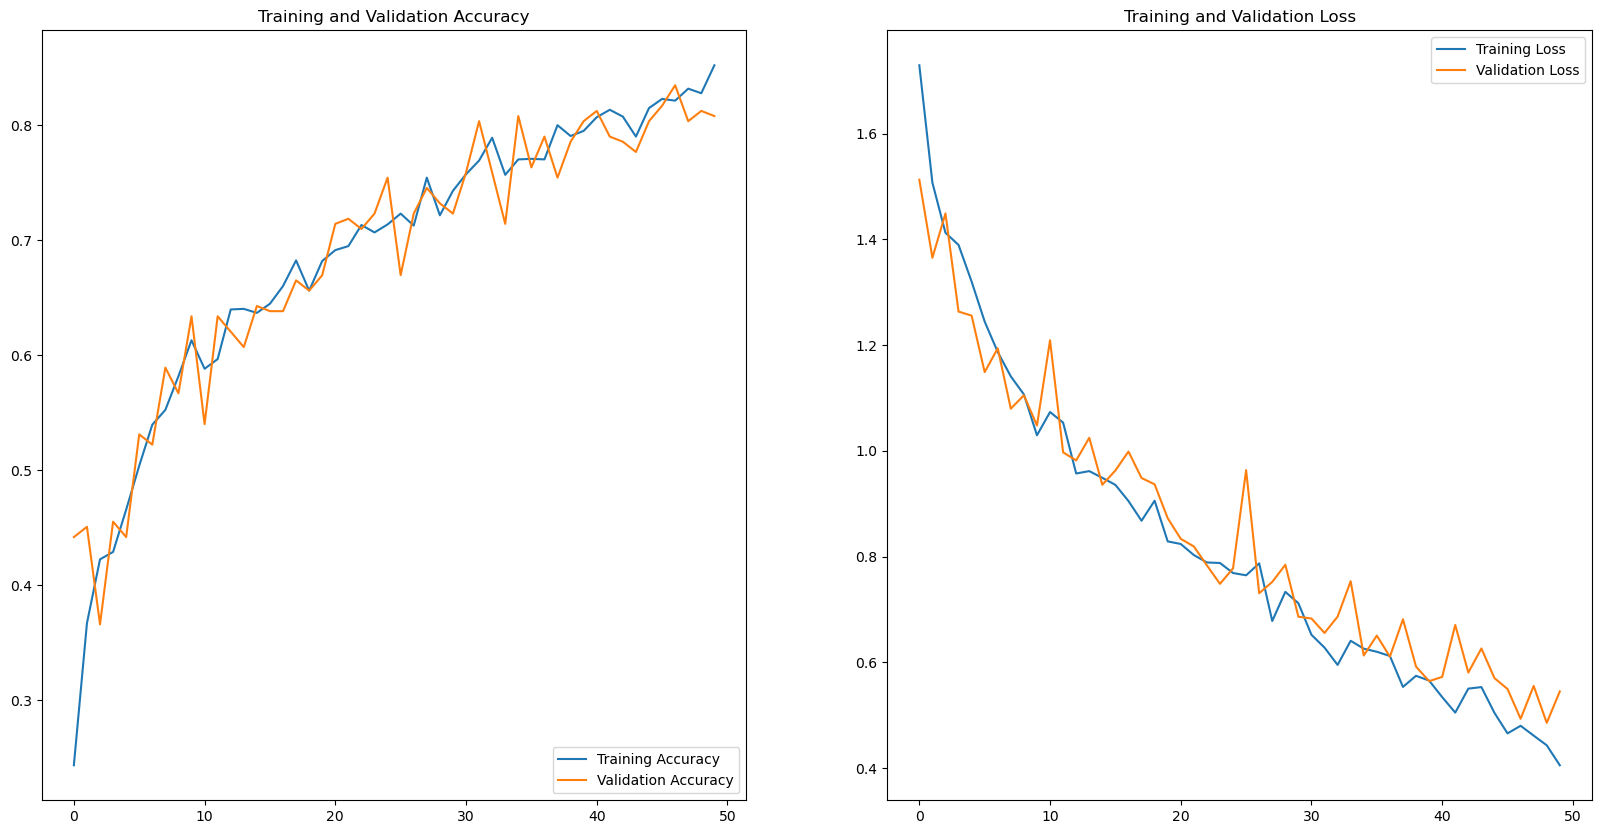

In [43]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
## prediction on a sample image with CNN Model

first image to predict
actual label: paper
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
predicted label: paper


2024-08-05 11:18:33.978117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


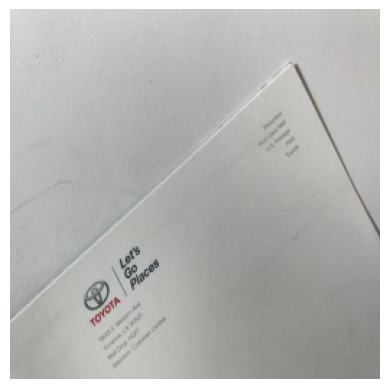

In [45]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    plt.axis("off")
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [46]:
## function for inference

In [47]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

## running inference on few sample images with CNN Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-08-05 11:18:50.806326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


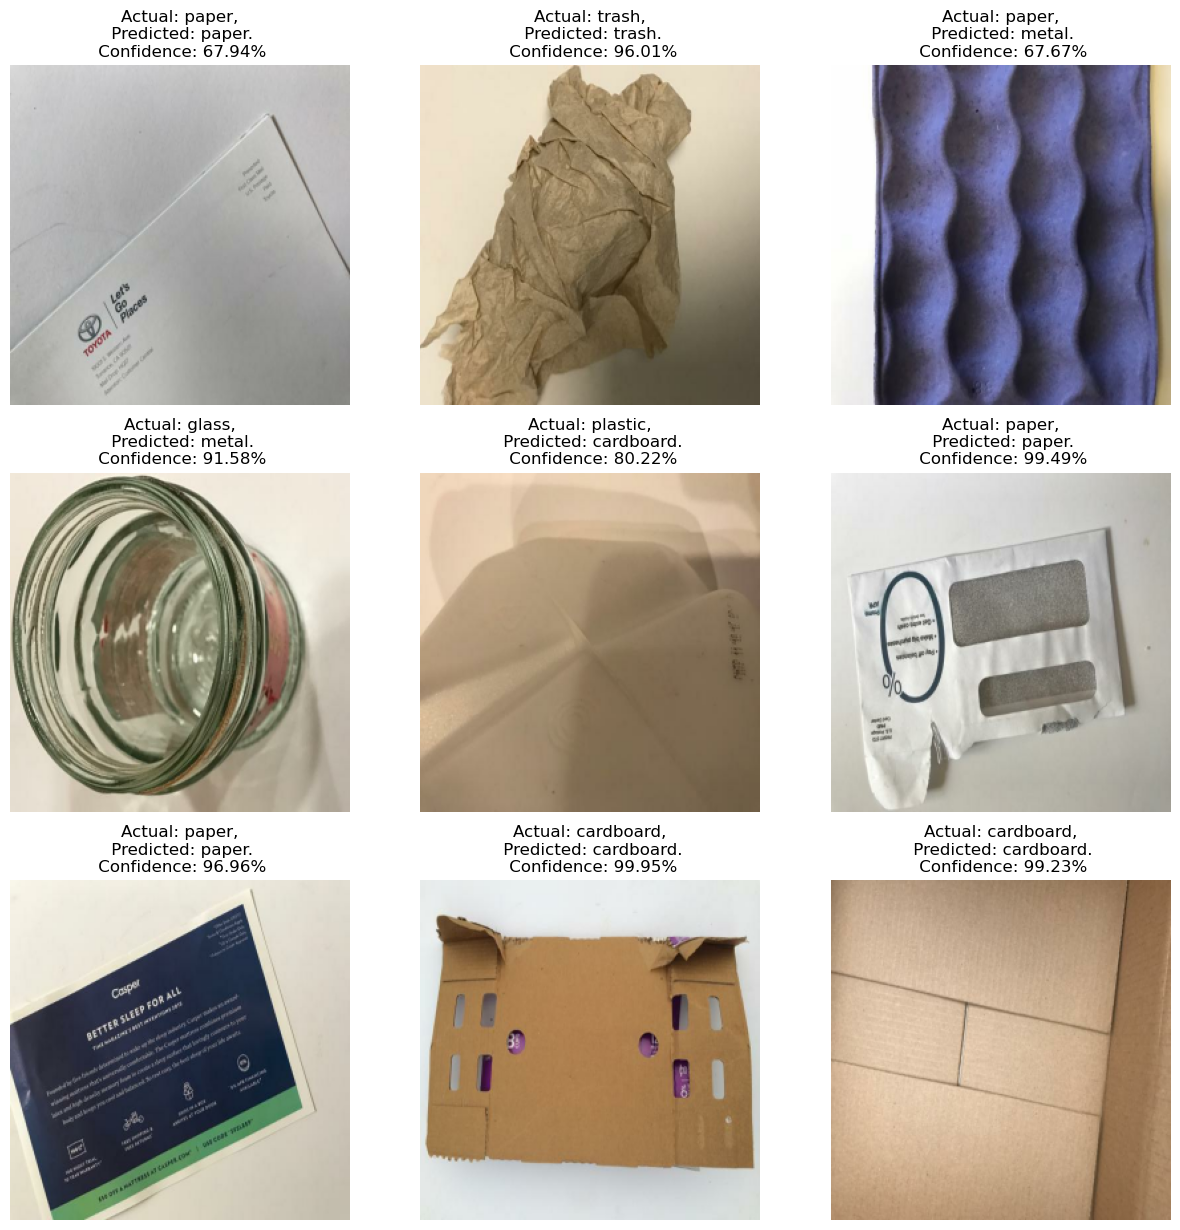

In [48]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")